In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision import models
import torchvision.transforms.functional as TF

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import math
from tqdm.notebook import tqdm 

DATA_DIR = "/kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training"

IMAGE_DIR = os.path.join(DATA_DIR, "frames")
MASK_DIR = os.path.join(DATA_DIR, "lane-masks")

# Model & Training Params
IMG_HEIGHT = 256 
IMG_WIDTH = 512 
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 25
VAL_SPLIT = 0.15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
AUX_LOSS_WEIGHT = 0.4 # Weight for the auxiliary loss

# --- Seed everything for reproducibility ---
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 

print(f"Using device: {DEVICE}")
print(f"Data directory structure expected:")
print(f"Images: {IMAGE_DIR}")
print(f"Masks: {MASK_DIR}")

Using device: cuda
Data directory structure expected:
Images: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames
Masks: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/lane-masks


In [2]:
class SEAttention(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- CBGA Module (Conv-BN-GELU-SE) ---
class CBGA(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, reduction=16):
        super(CBGA, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False) # Bias False because BN follows
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()
        self.se = SEAttention(out_channels, reduction)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        x = self.se(x)
        return x

# --- GhostConv Module (Simplified Implementation) ---
class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = math.ceil(oup / ratio)
        new_channels = init_channels*(ratio-1)

        # Primary convolution
        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

        # Cheap operation (Depthwise Conv)
        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_size, 1, dw_size//2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Identity(),
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1, x2], dim=1)
        return out[:, :self.oup, :, :]

class GhostConv(nn.Module):
     # Wraps GhostModule for easier use like a standard Conv layer replacement
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, relu=True):
        super(GhostConv, self).__init__()
        self.ghost = GhostModule(in_channels, out_channels, kernel_size=kernel_size, stride=stride, relu=relu)

    def forward(self, x):
        return self.ghost(x)

Total samples: 3626
Training samples: 3083
Validation samples: 543

Showing one sample from training loader:


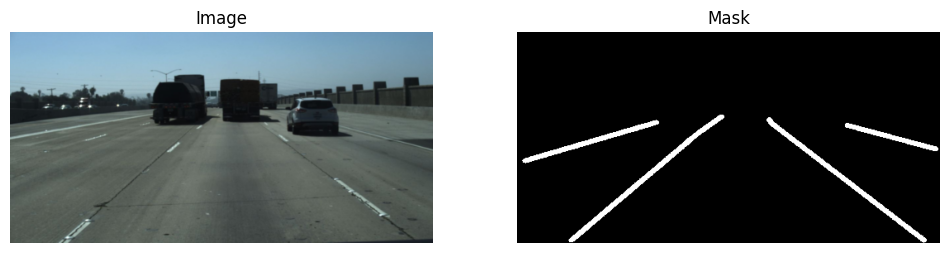

In [3]:
class TuSimpleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png') or f.endswith('.jpg')])

        # Basic check
        if len(self.image_filenames) != len(self.mask_filenames):
            print(f"Warning: Mismatch in number of images ({len(self.image_filenames)}) and masks ({len(self.mask_filenames)})")
            img_stems = {os.path.splitext(f)[0] for f in self.image_filenames}
            mask_stems = {os.path.splitext(f)[0] for f in self.mask_filenames}
            common_stems = list(img_stems.intersection(mask_stems))
            self.image_filenames = sorted([f for f in self.image_filenames if os.path.splitext(f)[0] in common_stems])
            self.mask_filenames = sorted([f for f in self.mask_filenames if os.path.splitext(f)[0] in common_stems])
            print(f"Aligned to {len(self.image_filenames)} common stems.")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Load mask as grayscale
        
        image = TF.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation=T.InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation=T.InterpolationMode.NEAREST) # Use NEAREST for masks

        if self.transform:
            image = self.transform(image) 

        if self.target_transform:
            mask = self.target_transform(mask) 
            mask = (mask > 0.5).float()

        return image, mask

image_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = T.Compose([
    T.ToTensor()
])

# Create the full dataset
full_dataset = TuSimpleDataset(
    image_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    transform=image_transforms,
    target_transform=mask_transforms
)

# Split dataset
n_val = int(len(full_dataset) * VAL_SPLIT)
n_train = len(full_dataset) - n_val
train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()//2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2)

print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# --- Verify data loading (Optional but recommended) ---
def show_sample(image, mask):
    inv_normalize = T.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    image = inv_normalize(image)
    image = image.permute(1, 2, 0).cpu().numpy() # C, H, W -> H, W, C
    mask = mask.squeeze().cpu().numpy() # Remove channel dim

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    plt.show()

print("\nShowing one sample from training loader:")
img, msk = next(iter(train_loader))
show_sample(img[0], msk[0])

In [4]:
class DecoderBlock(nn.Module):
    """ Standard U-Net like decoder block with optional CBGA """
    def __init__(self, in_channels, skip_channels, out_channels, use_cbga=False):
        super().__init__()
        self.use_cbga = use_cbga
        # Upsample and concatenate
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # Adjust channels after concatenation
        conv_in_channels = in_channels + skip_channels

        if use_cbga:
            self.conv1 = CBGA(conv_in_channels, out_channels, kernel_size=3, padding=1)
            self.conv2 = CBGA(out_channels, out_channels, kernel_size=3, padding=1)
        else: # Standard Conv block
            self.conv = nn.Sequential(
                nn.Conv2d(conv_in_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x, skip_features):
        x = self.up(x)
        # Pad skip features if necessary (sometimes off by 1 pixel)
        diffY = skip_features.size()[2] - x.size()[2]
        diffX = skip_features.size()[3] - x.size()[3]
        x = nn.functional.pad(x, [diffX // 2, diffX - diffX // 2,
                                  diffY // 2, diffY - diffY // 2])

        x = torch.cat([x, skip_features], dim=1)
        if self.use_cbga:
            x = self.conv1(x)
            x = self.conv2(x)
        else:
            x = self.conv(x)
        return x


class LaneDetectionModel(nn.Module):
    def __init__(self, n_classes=1, backbone_name='resnet34', pretrained=True, use_cbga_decoder=True, use_ghost_head=True):
        super().__init__()
        self.n_classes = n_classes
        self.use_ghost_head = use_ghost_head

        # --- Encoder (ResNet Backbone) ---
        if backbone_name == 'resnet34':
            backbone = models.resnet34(pretrained=pretrained)
            self.encoder_channels = [64, 64, 128, 256, 512] # Channels out per stage
        elif backbone_name == 'resnet50':
             backbone = models.resnet50(pretrained=pretrained)
             self.encoder_channels = [64, 256, 512, 1024, 2048] # ResNet50 uses bottleneck blocks
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        self.encoder_conv1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu) # Output: 64 channels, /2 scale
        self.encoder_pool1 = backbone.maxpool 
        self.encoder_layer1 = backbone.layer1
        self.encoder_layer2 = backbone.layer2 
        self.encoder_layer3 = backbone.layer3 
        self.encoder_layer4 = backbone.layer4 

        # --- Decoder ---
        self.decoder_block1 = DecoderBlock(self.encoder_channels[4], self.encoder_channels[3], 256, use_cbga=use_cbga_decoder) # /16
        self.decoder_block2 = DecoderBlock(256, self.encoder_channels[2], 128, use_cbga=use_cbga_decoder) # /8
        self.decoder_block3 = DecoderBlock(128, self.encoder_channels[1], 64, use_cbga=use_cbga_decoder) # /4
        self.decoder_block4 = DecoderBlock(64, self.encoder_channels[0], 32, use_cbga=use_cbga_decoder) # /2

        # --- Final Segmentation Head ---
        self.upsample_final = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        if use_ghost_head:
            self.final_conv1 = GhostConv(32, 32, kernel_size=3) # Keep channels 32
            self.final_conv2 = nn.Conv2d(32, n_classes, kernel_size=1) # 1x1 conv to get classes
        else:
            self.final_conv = nn.Sequential(
                 nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
                 nn.BatchNorm2d(32),
                 nn.ReLU(inplace=True),
                 nn.Conv2d(32, n_classes, kernel_size=1) # 1x1 conv to get classes
            )

        # Attaching to output of encoder_layer3 (/16 scale)
        aux_in_channels = self.encoder_channels[3]
        self.aux_head = nn.Sequential(
            nn.Conv2d(aux_in_channels, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, n_classes, kernel_size=1) # Predict classes directly
        )


    def forward(self, x):
        # --- Encoder ---
        enc_conv1 = self.encoder_conv1(x)      # /2
        enc_pool1 = self.encoder_pool1(enc_conv1) # /4
        enc_layer1 = self.encoder_layer1(enc_pool1) # /4, skip[1]
        enc_layer2 = self.encoder_layer2(enc_layer1) # /8, skip[2]
        enc_layer3 = self.encoder_layer3(enc_layer2) # /16, skip[3]
        enc_layer4 = self.encoder_layer4(enc_layer3) # /32, bottleneck

        # --- Auxiliary Head ---
        aux_logits = self.aux_head(enc_layer3) # Output is /16 scale
        aux_logits_upsampled = nn.functional.interpolate(
            aux_logits,
            size=x.shape[2:], # Original input size H, W
            mode='bilinear',
            align_corners=False
        )

        # --- Decoder ---
        dec1 = self.decoder_block1(enc_layer4, enc_layer3) # /16
        dec2 = self.decoder_block2(dec1, enc_layer2)       # /8
        dec3 = self.decoder_block3(dec2, enc_layer1)       # /4
        dec4 = self.decoder_block4(dec3, enc_conv1)        # /2

        # --- Final Head ---
        final_up = self.upsample_final(dec4) # /1 (original size)

        if self.use_ghost_head:
            final_ghost = self.final_conv1(final_up)
            main_logits = self.final_conv2(final_ghost)
        else:
             main_logits = self.final_conv(final_up)

        return main_logits, aux_logits_upsampled

# Instantiate the model
model = LaneDetectionModel(
    n_classes=1, # Binary: lane or not lane
    backbone_name='resnet34',
    pretrained=True,
    use_cbga_decoder=True,
    use_ghost_head=True
).to(DEVICE)

# --- Test forward pass (Optional) ---
try:
    with torch.no_grad():
        sample_img, _ = next(iter(train_loader))
        sample_img = sample_img.to(DEVICE)
        model.eval()
        main_out, aux_out = model(sample_img)
        print(f"Model instantiated successfully.")
        print(f"Input shape: {sample_img.shape}")
        print(f"Main output shape: {main_out.shape}") # Should be [B, 1, H, W]
        print(f"Aux output shape: {aux_out.shape}")   # Should be [B, 1, H, W]
        model.train() # Set back to train mode
except Exception as e:
    print(f"Error during model instantiation or forward pass: {e}")
    raise e

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 236MB/s]


Model instantiated successfully.
Input shape: torch.Size([8, 3, 256, 512])
Main output shape: torch.Size([8, 1, 256, 512])
Aux output shape: torch.Size([8, 1, 256, 512])


In [5]:
criterion = nn.BCEWithLogitsLoss()

def combined_loss(main_pred, aux_pred, target, aux_weight=AUX_LOSS_WEIGHT):
    main_loss = criterion(main_pred, target)
    aux_loss = criterion(aux_pred, target)
    return main_loss + aux_weight * aux_loss

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
def calculate_iou(pred, target, threshold=0.5):
    """Calculates Intersection over Union (IoU) for binary segmentation."""
    pred = torch.sigmoid(pred) > threshold 
    pred = pred.byte() 
    target = target.byte()

    intersection = (pred & target).float().sum((1, 2)) # Sum over H, W dims
    union = (pred | target).float().sum((1, 2))

    iou = (intersection + 1e-6) / (union + 1e-6)

    iou[union == 0] = 1.0

    return iou.mean() 

In [7]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        main_preds, aux_preds = model(images)

        loss = combined_loss(main_preds, aux_preds, masks, AUX_LOSS_WEIGHT)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return epoch_loss / len(loader)


def evaluate(model, loader, device):
    model.eval()
    epoch_loss = 0.0
    epoch_iou = 0.0
    progress_bar = tqdm(loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            main_preds, aux_preds = model(images)

            loss = combined_loss(main_preds, aux_preds, masks, AUX_LOSS_WEIGHT)
            epoch_loss += loss.item()

            iou = calculate_iou(main_preds, masks)
            epoch_iou += iou.item()

            progress_bar.set_postfix(loss=loss.item(), iou=iou.item())

    avg_loss = epoch_loss / len(loader)
    avg_iou = epoch_iou / len(loader)
    return avg_loss, avg_iou

Starting Training for 10 epochs...

--- Epoch 1/10 ---


Training Epoch 1:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Loss: 0.5506
  Val Loss:   0.4216
  Val IoU:    0.5715
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 2/10 ---


Training Epoch 2:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Loss: 0.3469
  Val Loss:   0.2906
  Val IoU:    0.6237
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 3/10 ---


Training Epoch 3:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Loss: 0.2505
  Val Loss:   0.2175
  Val IoU:    0.6261
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 4/10 ---


Training Epoch 4:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Loss: 0.1859
  Val Loss:   0.1664
  Val IoU:    0.6316
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 5/10 ---


Training Epoch 5:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Loss: 0.1436
  Val Loss:   0.1329
  Val IoU:    0.6527
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 6/10 ---


Training Epoch 6:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6 Summary:
  Train Loss: 0.1169
  Val Loss:   0.1124
  Val IoU:    0.6621
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 7/10 ---


Training Epoch 7:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7 Summary:
  Train Loss: 0.0990
  Val Loss:   0.1000
  Val IoU:    0.6719
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

--- Epoch 8/10 ---


Training Epoch 8:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8 Summary:
  Train Loss: 0.0864
  Val Loss:   0.0917
  Val IoU:    0.6707
  Validation IoU (0.6707) did not improve from 0.6719

--- Epoch 9/10 ---


Training Epoch 9:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9 Summary:
  Train Loss: 0.0768
  Val Loss:   0.0875
  Val IoU:    0.6692
  Validation IoU (0.6692) did not improve from 0.6719

--- Epoch 10/10 ---


Training Epoch 10:   0%|          | 0/386 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10 Summary:
  Train Loss: 0.0692
  Val Loss:   0.0830
  Val IoU:    0.6785
  New best model found! Saving model checkpoint...
  Model saved to /kaggle/working/best_lane_detection_model.pth

Training Finished!
Best Validation IoU achieved across 10 epochs: 0.6785


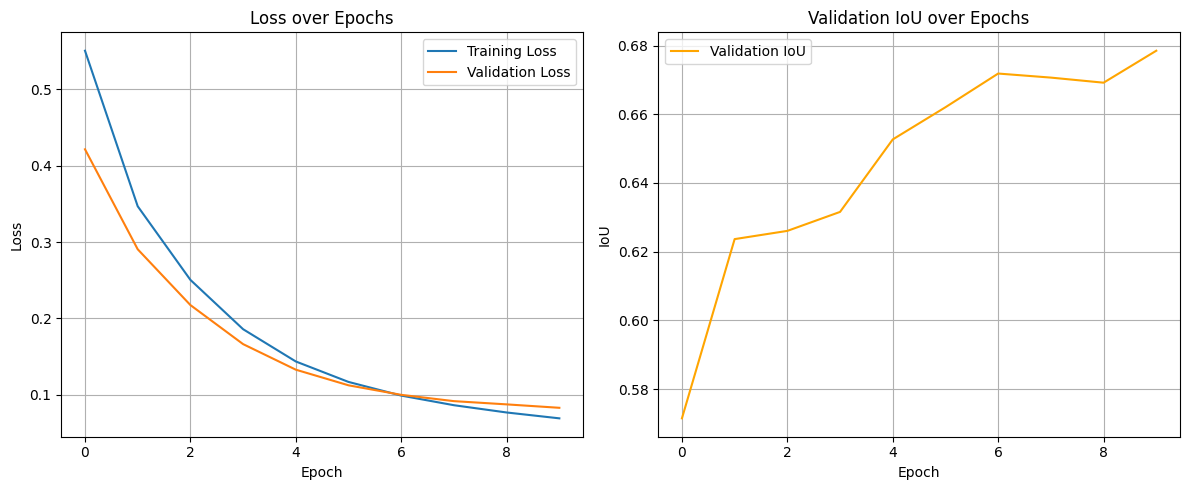

In [8]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

best_val_iou = -1.0
history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
NUM_EPOCHS_TO_RUN = 10 

print(f"Starting Training for {NUM_EPOCHS_TO_RUN} epochs...")

for epoch in range(NUM_EPOCHS_TO_RUN): 
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS_TO_RUN} ---") # <--- Updated print statement

    # --- Training Step ---
    model.train()
    epoch_train_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
    for images, masks in train_progress_bar:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        optimizer.zero_grad()
        main_preds, aux_preds = model(images)
        loss = combined_loss(main_preds, aux_preds, masks) # Assumes AUX_LOSS_WEIGHT is defined globally or passed
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())
    train_loss = epoch_train_loss / len(train_loader)

    # --- Validation Step ---
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_iou = 0.0
    val_progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False)
    with torch.no_grad():
        for images, masks in val_progress_bar:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            main_preds, aux_preds = model(images)
            loss = combined_loss(main_preds, aux_preds, masks)
            iou = calculate_iou(main_preds, masks) # Assumes threshold is default 0.5 or defined globally
            epoch_val_loss += loss.item()
            epoch_val_iou += iou.item()
            val_progress_bar.set_postfix(loss=loss.item(), iou=iou.item())
    val_loss = epoch_val_loss / len(val_loader)
    val_iou = epoch_val_iou / len(val_loader)


    # --- Log History ---
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)

    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val IoU:    {val_iou:.4f}")

    if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
         scheduler.step(val_loss) # Step based on validation loss

    # --- Save Best Model ---
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        print(f"  New best model found! Saving model checkpoint...")
        # Make sure the path is writable in Kaggle ('/kaggle/working/' is usually safe)
        save_path = '/kaggle/working/best_lane_detection_model.pth'
        torch.save(model.state_dict(), save_path)
        print(f"  Model saved to {save_path}")
    else:
        print(f"  Validation IoU ({val_iou:.4f}) did not improve from {best_val_iou:.4f}")


print("\nTraining Finished!")
print(f"Best Validation IoU achieved across {NUM_EPOCHS_TO_RUN} epochs: {best_val_iou:.4f}")

# --- Plotting Results (Optional but recommended) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Validation IoU', color='orange')
plt.title('Validation IoU over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import numpy as np
import os

IMG_HEIGHT = 256
IMG_WIDTH = 512
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = '/kaggle/working/best_lane_detection_model.pth' # Path where the best model was saved


test_image_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def predict_single_image(model, image_path, device, transforms):
    """Loads an image, preprocesses it, makes a prediction, and returns results."""
    try:
        img = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, None

    # --- Preprocessing ---
    original_size = img.size # Store original size if needed later (W, H)
    img_resized = TF.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation=T.InterpolationMode.BILINEAR)

    # 2. Apply other transforms (ToTensor, Normalize)
    img_tensor = transforms(img_resized)

    # 3. Add batch dimension and send to device
    input_batch = img_tensor.unsqueeze(0).to(device) # Shape: [1, C, H, W]

    # --- Inference ---
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        main_logits, _ = model(input_batch) # We only need the main output for prediction

    # --- Post-processing ---
    pred_probs = torch.sigmoid(main_logits.squeeze(0)) # Remove batch dim, shape: [1, H, W]
    pred_mask = (pred_probs > 0.5).cpu().numpy().squeeze() # Threshold and convert to numpy [H, W]

    # --- Prepare original image for display ---
    img_display = inv_normalize(img_tensor)
    img_display_np = img_display.permute(1, 2, 0).cpu().numpy() # C, H, W -> H, W, C

    return img_display_np, pred_mask.astype(np.uint8) # Return image and mask

def visualize_prediction(image_np, predicted_mask_np):
    """Displays the original image and the predicted mask."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Input Image (Resized)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask_np, cmap='gray') # Display mask in grayscale
    plt.title("Predicted Lane Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Load the saved model ---
print("Instantiating model architecture...")
inference_model = LaneDetectionModel(
    n_classes=1,
    backbone_name='resnet34',
    pretrained=False, # Set pretrained=False, we are loading weights manually
    use_cbga_decoder=True,
    use_ghost_head=True
).to(DEVICE)

print(f"Loading saved model weights from: {MODEL_SAVE_PATH}")
try:
    inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print("Model weights loaded successfully.")
    inference_model.eval() 
except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_SAVE_PATH}. Cannot perform inference.")
except Exception as e:
     print(f"ERROR: Failed to load model weights: {e}")

Instantiating model architecture...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading saved model weights from: /kaggle/working/best_lane_detection_model.pth
Model weights loaded successfully.


/tmp/ipykernel_19/3766765056.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))


Using validation image: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames/0313-2_10200.jpg


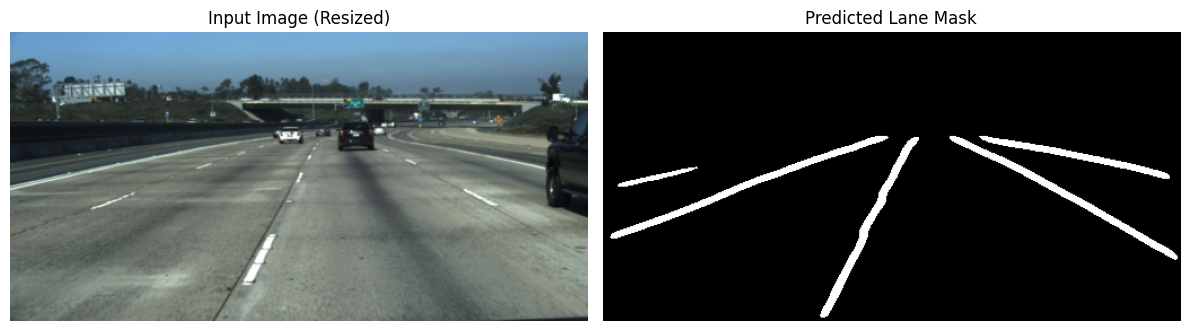

In [10]:
# --- Get a sample image path from the validation set ---
if 'val_dataset' in locals() and len(val_dataset) > 0:
    # Get the original dataset index from the Subset
    original_idx = val_dataset.indices[0] # Get the index of the first validation sample
    test_image_filename = full_dataset.image_filenames[original_idx]
    test_image_path = os.path.join(IMAGE_DIR, test_image_filename) # Construct full path
    print(f"Using validation image: {test_image_path}")

    # --- Run Prediction and Visualization ---
    input_img_np, predicted_mask = predict_single_image(
        inference_model,
        test_image_path,
        DEVICE,
        test_image_transforms
    )

    if input_img_np is not None:
        visualize_prediction(input_img_np, predicted_mask)
    else:
        print("Prediction failed.")

else:
    print("Validation dataset ('val_dataset') not found or is empty. Cannot get sample image path.")
    print("Please provide a specific 'test_image_path' manually (see Option B or C).")


--- Displaying predictions for 5 validation images ---

(1/5) Predicting for: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames/0313-2_10200.jpg


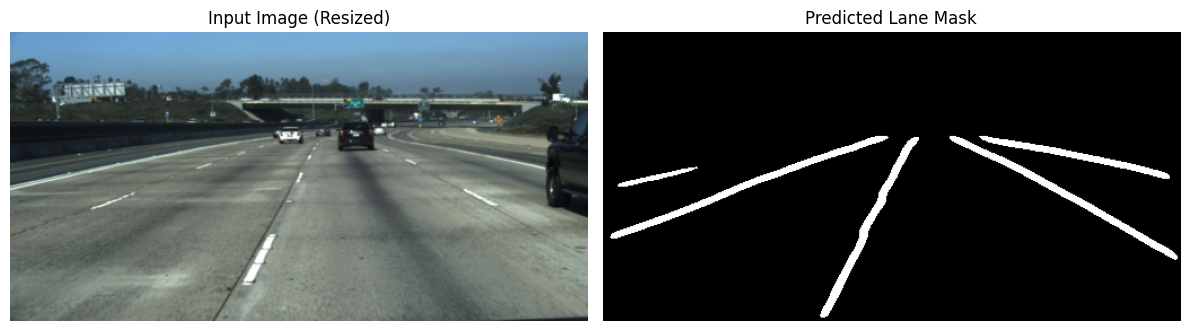


(2/5) Predicting for: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames/0313-2_11100.jpg


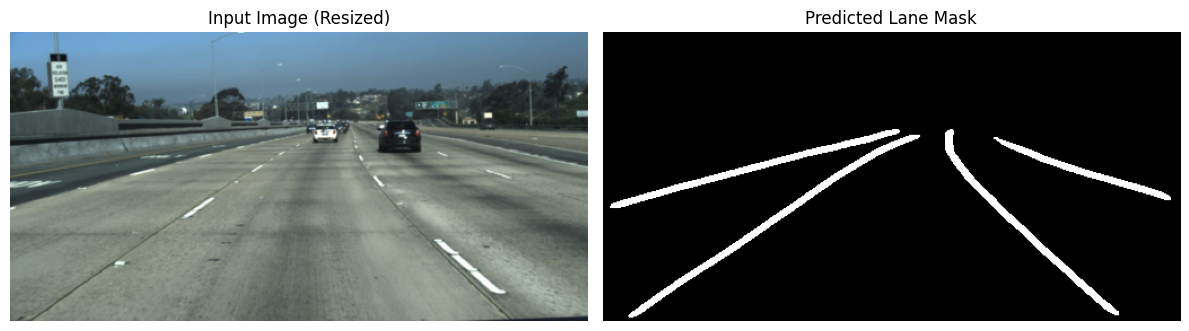


(3/5) Predicting for: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames/0313-1_38040.jpg


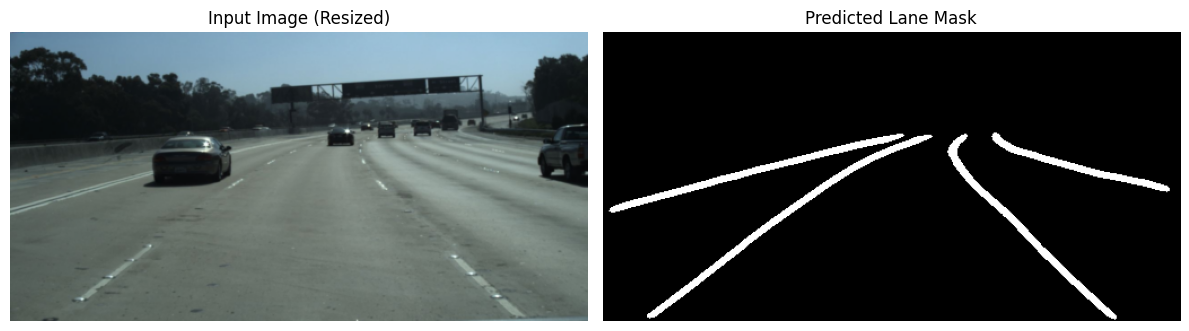


(4/5) Predicting for: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames/0313-2_14880.jpg


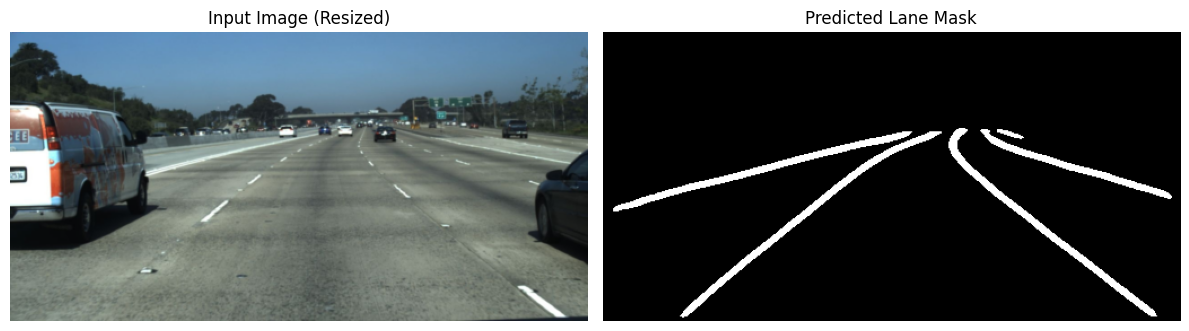


(5/5) Predicting for: /kaggle/input/tusimple-preprocessed-dataset/tusimple_preprocessed/training/frames/0601_1494453021813123637.jpg


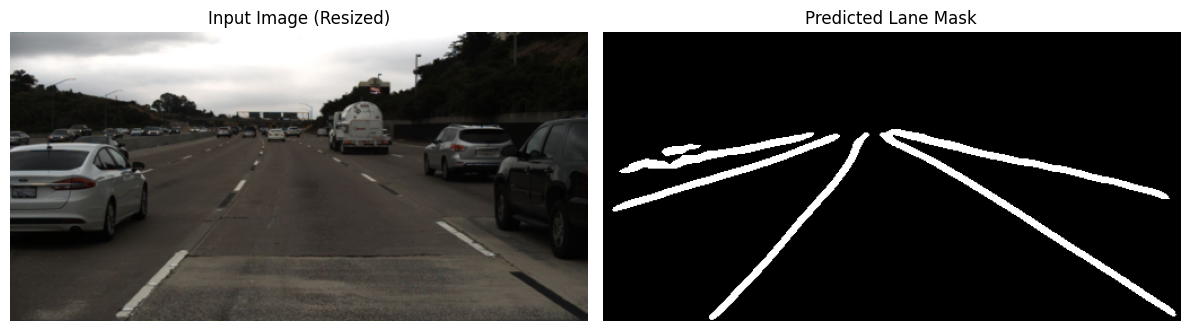

In [11]:
import os
import random 

NUM_PREDICTIONS_TO_SHOW = 5

# Check if required variables/functions exist from previous cells
required_vars = ['val_dataset', 'full_dataset', 'IMAGE_DIR', 'inference_model', 'DEVICE', 'test_image_transforms']
required_funcs = ['predict_single_image', 'visualize_prediction']

proceed = True
for var in required_vars:
    if var not in locals():
        print(f"Error: Variable '{var}' not found. Please ensure previous cells have run.")
        proceed = False
for func in required_funcs:
     if func not in locals():
        print(f"Error: Function '{func}' not found. Please ensure previous cells have run.")
        proceed = False

if 'inference_model' not in locals() or inference_model is None:
     print("Error: 'inference_model' is not loaded or is None. Cannot perform inference.")
     proceed = False
elif not hasattr(inference_model, 'load_state_dict'): # Basic check if it looks like a model
    print("Error: 'inference_model' does not seem to be a valid PyTorch model.")
    proceed = False


if proceed and 'val_dataset' in locals() and len(val_dataset) > 0:
    num_available = len(val_dataset)
    num_to_show = min(NUM_PREDICTIONS_TO_SHOW, num_available) # Don't try to show more than available

    if num_to_show < NUM_PREDICTIONS_TO_SHOW:
        print(f"Warning: Only {num_available} images available in validation set, showing {num_to_show}.")

    # --- Option 1: Get the first N samples ---
    sample_indices = val_dataset.indices[:num_to_show]

    print(f"\n--- Displaying predictions for {num_to_show} validation images ---")

    for i, original_idx in enumerate(sample_indices):
        try:
            # Get the corresponding filename from the full dataset object
            test_image_filename = full_dataset.image_filenames[original_idx]
            test_image_path = os.path.join(IMAGE_DIR, test_image_filename) # Construct full path

            print(f"\n({i+1}/{num_to_show}) Predicting for: {test_image_path}")

            # --- Run Prediction ---
            input_img_np, predicted_mask = predict_single_image(
                inference_model,
                test_image_path,
                DEVICE,
                test_image_transforms
            )

            # --- Visualize ---
            if input_img_np is not None:
                visualize_prediction(input_img_np, predicted_mask)
            else:
                print(f"Prediction failed for image: {test_image_filename}")

        except IndexError:
             print(f"Error: Could not access filename for index {original_idx}. Skipping.")
        except Exception as e:
             print(f"An error occurred processing index {original_idx} ({test_image_filename}): {e}")


elif proceed:
    print("Validation dataset ('val_dataset') not found or is empty.")
    print("Cannot automatically select images. Please provide specific image paths manually.")
    # You could add manual path loop here if desired

else:
    print("Cannot proceed with prediction due to missing variables, functions, or unloaded model.")

Starting evaluation on the validation set...


Evaluating Metrics:   0%|          | 0/68 [00:00<?, ?it/s]


--- Evaluation Metrics ---
Total True Positives (TP):  2373109
Total False Positives (FP): 627394
Total True Negatives (TN):  67485755
Total False Negatives (FN): 685838
-------------------------
Overall Accuracy:  0.9815
Overall Precision: 0.7909
Overall Recall:    0.7758
Overall IoU:       0.6438
-------------------------


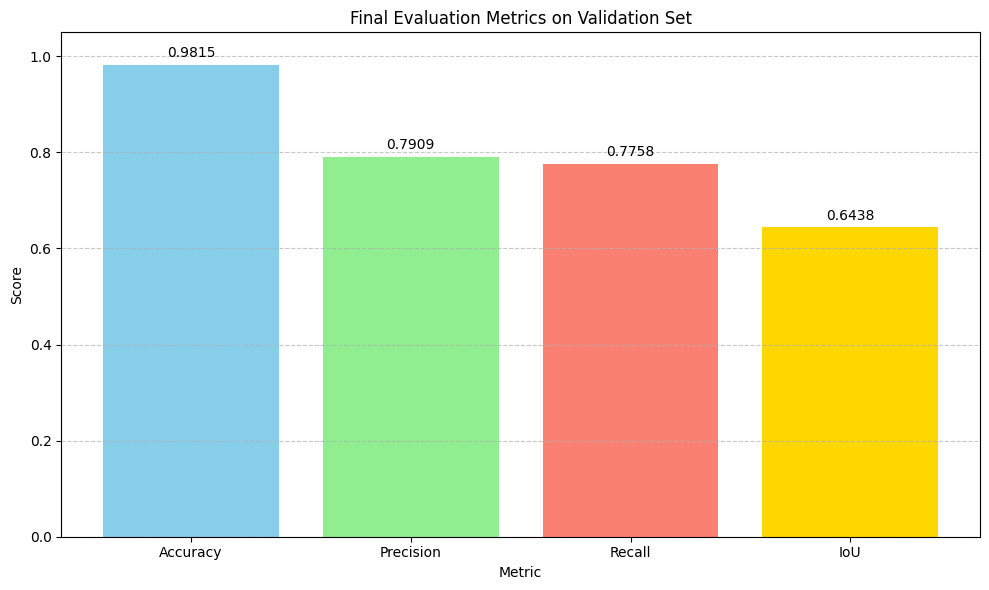

In [12]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

# --- Ensure necessary variables and functions are available ---
required_vars = ['val_loader', 'inference_model', 'DEVICE']
proceed = True
for var in required_vars:
    if var not in locals():
        print(f"Error: Variable '{var}' not found. Please ensure previous cells have run.")
        proceed = False

if 'inference_model' not in locals() or inference_model is None:
     print("Error: 'inference_model' is not loaded or is None. Cannot perform evaluation.")
     proceed = False
elif not hasattr(inference_model, 'load_state_dict'): 
    print("Error: 'inference_model' does not seem to be a valid PyTorch model.")
    proceed = False


# --- Evaluation Function (Updated) ---
def evaluate_segmentation_metrics(model, loader, device, threshold=0.5):
    """Calculates pixel-wise accuracy, precision, recall, and IoU for segmentation."""
    model.eval()
    total_tp = 0
    total_fp = 0
    total_tn = 0
    total_fn = 0

    progress_bar = tqdm(loader, desc="Evaluating Metrics", leave=False)
    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device).bool() # Convert masks to boolean (True/False or 1/0)

            # Forward pass - only need main prediction
            main_logits, _ = model(images)

            # Get binary predictions
            preds_prob = torch.sigmoid(main_logits)
            preds_binary = (preds_prob > threshold).bool() # Convert predictions to boolean

            # Ensure shapes match for comparison (squeeze channel dim if needed)
            if preds_binary.dim() == 4 and preds_binary.shape[1] == 1:
                preds_binary = preds_binary.squeeze(1)
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)

            # Calculate TP, FP, TN, FN for the batch using boolean logic
            tp = (preds_binary & masks).sum().item()
            fp = (preds_binary & ~masks).sum().item()
            tn = (~preds_binary & ~masks).sum().item()
            fn = (~preds_binary & masks).sum().item()

            total_tp += tp
            total_fp += fp
            total_tn += tn
            total_fn += fn


    # Calculate overall metrics from accumulated counts
    epsilon = 1e-6 # To avoid division by zero
    accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn + epsilon)
    precision = total_tp / (total_tp + total_fp + epsilon)
    recall = total_tp / (total_tp + total_fn + epsilon)
    # Calculate global IoU (Intersection over Union)
    iou = total_tp / (total_tp + total_fp + total_fn + epsilon)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'iou': iou, # Add IoU here
        'total_tp': total_tp,
        'total_fp': total_fp,
        'total_tn': total_tn,
        'total_fn': total_fn
    }
    return metrics

# --- Run Evaluation ---
if proceed:
    print("Starting evaluation on the validation set...")
    evaluation_results = evaluate_segmentation_metrics(inference_model, val_loader, DEVICE)

    print("\n--- Evaluation Metrics ---")
    print(f"Total True Positives (TP):  {evaluation_results['total_tp']}")
    print(f"Total False Positives (FP): {evaluation_results['total_fp']}")
    print(f"Total True Negatives (TN):  {evaluation_results['total_tn']}")
    print(f"Total False Negatives (FN): {evaluation_results['total_fn']}")
    print("-" * 25)
    print(f"Overall Accuracy:  {evaluation_results['accuracy']:.4f}")
    print(f"Overall Precision: {evaluation_results['precision']:.4f}")
    print(f"Overall Recall:    {evaluation_results['recall']:.4f}")
    print(f"Overall IoU:       {evaluation_results['iou']:.4f}") # Print IoU
    print("-" * 25)

    # --- Plotting the Results (Updated) ---
    metrics_to_plot = {
        'Accuracy': evaluation_results['accuracy'],
        'Precision': evaluation_results['precision'],
        'Recall': evaluation_results['recall'],
        'IoU': evaluation_results['iou'] # Add IoU to plot
    }
    names = list(metrics_to_plot.keys())
    values = list(metrics_to_plot.values())

    plt.figure(figsize=(10, 6)) # Increased figure size slightly for 4 bars
    # Define colors for the bars
    colors = ['skyblue', 'lightgreen', 'salmon', 'gold']
    bars = plt.bar(names, values, color=colors[:len(names)]) # Use dynamic colors
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Final Evaluation Metrics on Validation Set")
    plt.ylim(0, 1.05) # Set y-axis limits slightly above 1.0

    # Add text labels above bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', va='bottom', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout
    plt.show()

else:
    print("Cannot proceed with evaluation due to missing variables or unloaded model.")

# Optimizations

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
# --- Ensure necessary variables and functions are available ---
required_vars = [
    'inference_model', 'train_loader', 'val_loader', 'DEVICE', 'IMAGE_DIR',
    'LaneDetectionModel', 'full_dataset' # Needed for train_one_epoch if it uses global full_dataset for something
]
required_funcs = ['evaluate_segmentation_metrics', 'train_one_epoch', 'calculate_iou'] # calculate_iou is used by evaluate function

proceed_optimization = True
for var in required_vars:
    if var not in locals():
        print(f"Error: Variable '{var}' not found. Please ensure previous cells have run.")
        proceed_optimization = False
for func in required_funcs:
     if func not in locals():
        print(f"Error: Function '{func}' not found. Please ensure previous cells have run.")
        proceed_optimization = False

if 'inference_model' not in locals() or inference_model is None:
     print("Error: 'inference_model' is not loaded or is None. Cannot perform optimization.")
     proceed_optimization = False

In [15]:
# --- 1. Define Dice Loss ---
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits to get probabilities
        probs = torch.sigmoid(logits)

        # Flatten label and prediction tensors
        probs = probs.view(-1)
        targets = targets.view(-1)

        intersection = (probs * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)

        return 1 - dice_coeff # We want to minimize 1 - DiceCoefficient

In [16]:
# --- 2. Create a New Combined Loss (BCE + Dice) ---
bce_criterion_opt = nn.BCEWithLogitsLoss()
dice_criterion_opt = DiceLoss()
AUX_LOSS_WEIGHT_OPT = 0.4 # Same as before, or you can tune this

def combined_loss_bce_dice(main_pred, aux_pred, target, main_bce_weight=0.5, main_dice_weight=0.5, aux_weight=AUX_LOSS_WEIGHT_OPT):
    # Main Losses
    main_bce_loss = bce_criterion_opt(main_pred, target)
    main_dice_loss = dice_criterion_opt(main_pred, target) # Dice loss expects logits for internal sigmoid
    main_combined_loss = (main_bce_weight * main_bce_loss) + (main_dice_weight * main_dice_loss)

    # Auxiliary Loss (still BCE)
    aux_loss_val = bce_criterion_opt(aux_pred, target)

    return main_combined_loss + aux_weight * aux_loss_val

In [17]:
# --- Optimization Parameters for Fine-tuning ---
FINETUNE_EPOCHS = 5 
FINETUNE_LR = 1e-5   
OPTIMIZED_MODEL_SAVE_PATH = '/kaggle/working/best_lane_detection_model_dice_optimized.pth'

if proceed_optimization:
    print("--- Optimization Step: Incorporating Dice Loss ---")

--- Optimization Step: Incorporating Dice Loss ---



Evaluating model BEFORE Dice Loss optimization...


Evaluating Metrics:   0%|          | 0/68 [00:00<?, ?it/s]

Metrics BEFORE optimization:
  Accuracy: 0.9815
  Precision: 0.7909
  Recall: 0.7758
  Iou: 0.6438
  Total Tp: 2373109
  Total Fp: 627394
  Total Tn: 67485755
  Total Fn: 685838

Starting fine-tuning for 5 epochs with BCE+Dice loss and LR=1e-05...


Finetune Epoch 1 Training:   0%|          | 0/386 [00:00<?, ?it/s]

Finetune Epoch 1 Validation:   0%|          | 0/68 [00:00<?, ?it/s]

Finetune Epoch 1/5 - Train Loss: 0.1749, Val Loss: 0.2188, Val IoU (batch avg): 0.6887
  New best finetune val IoU: 0.6887. Saving optimized model to /kaggle/working/best_lane_detection_model_dice_optimized.pth


Finetune Epoch 2 Training:   0%|          | 0/386 [00:00<?, ?it/s]

Finetune Epoch 2 Validation:   0%|          | 0/68 [00:00<?, ?it/s]

Finetune Epoch 2/5 - Train Loss: 0.1608, Val Loss: 0.2141, Val IoU (batch avg): 0.6891
  New best finetune val IoU: 0.6891. Saving optimized model to /kaggle/working/best_lane_detection_model_dice_optimized.pth


Finetune Epoch 3 Training:   0%|          | 0/386 [00:00<?, ?it/s]

Finetune Epoch 3 Validation:   0%|          | 0/68 [00:00<?, ?it/s]

Finetune Epoch 3/5 - Train Loss: 0.1507, Val Loss: 0.2105, Val IoU (batch avg): 0.6866
  Finetune val IoU (0.6866) did not improve from 0.6891


Finetune Epoch 4 Training:   0%|          | 0/386 [00:00<?, ?it/s]

Finetune Epoch 4 Validation:   0%|          | 0/68 [00:00<?, ?it/s]

Finetune Epoch 4/5 - Train Loss: 0.1422, Val Loss: 0.2079, Val IoU (batch avg): 0.6864
  Finetune val IoU (0.6864) did not improve from 0.6891


Finetune Epoch 5 Training:   0%|          | 0/386 [00:00<?, ?it/s]

Finetune Epoch 5 Validation:   0%|          | 0/68 [00:00<?, ?it/s]

Finetune Epoch 5/5 - Train Loss: 0.1346, Val Loss: 0.2055, Val IoU (batch avg): 0.6860
  Finetune val IoU (0.6860) did not improve from 0.6891

Fine-tuning finished.
Loading best fine-tuned model from /kaggle/working/best_lane_detection_model_dice_optimized.pth

Evaluating model AFTER Dice Loss optimization and fine-tuning...


/tmp/ipykernel_19/548876826.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inference_model.load_state_dict(torch.load(OPTIMIZED_MODEL_SAVE_PATH, map_location=DEVICE))


Evaluating Metrics:   0%|          | 0/68 [00:00<?, ?it/s]

Metrics AFTER optimization:
  Accuracy: 0.9819
  Precision: 0.7824
  Recall: 0.8034
  Iou: 0.6566
  Total Tp: 2457446
  Total Fp: 683462
  Total Tn: 67429687
  Total Fn: 601501

--- Comparison of Metrics (Before vs After Dice Loss Optimization) ---
Metric       | Before     | After      | Change    
--------------------------------------------------
Accuracy     | 0.9815     | 0.9819     | +0.0004   
Precision    | 0.7909     | 0.7824     | -0.0085   
Recall       | 0.7758     | 0.8034     | +0.0276   
Iou          | 0.6438     | 0.6566     | +0.0129   


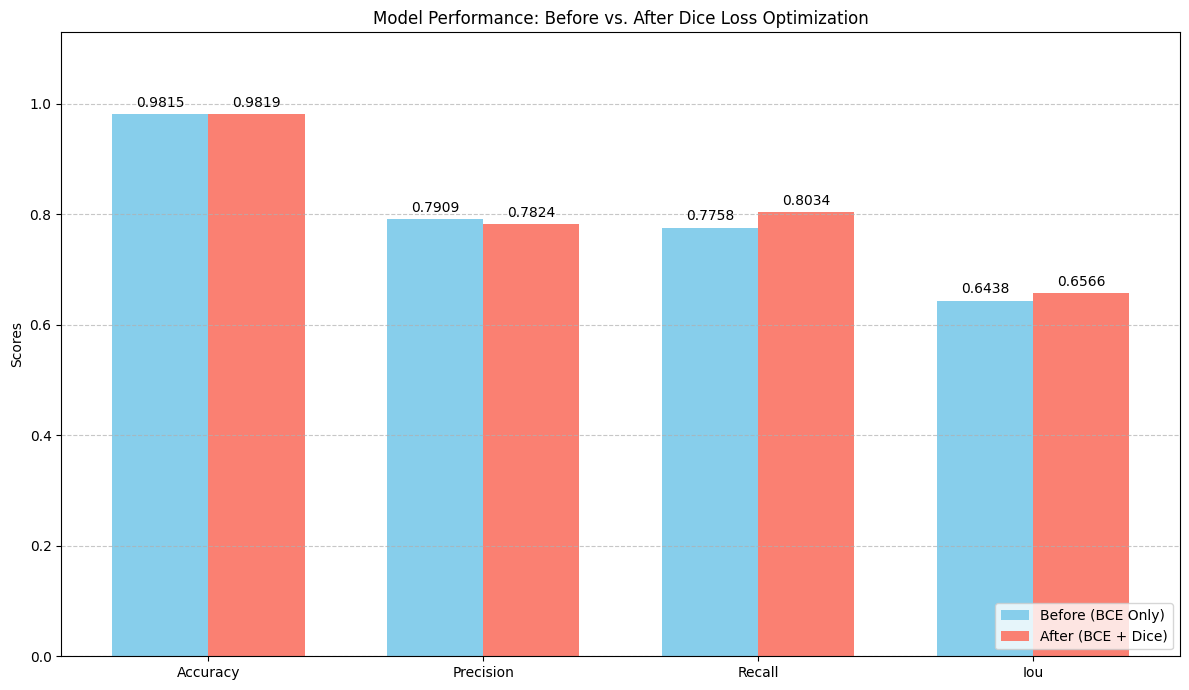

In [18]:
# --- 3. Evaluate "Before" Optimization ---
print("\nEvaluating model BEFORE Dice Loss optimization...")
metrics_before = evaluate_segmentation_metrics(inference_model, val_loader, DEVICE)
print("Metrics BEFORE optimization:")
for key, val in metrics_before.items():
    if isinstance(val, float): print(f"  {key.replace('_', ' ').title()}: {val:.4f}")
    else: print(f"  {key.replace('_', ' ').title()}: {val}")

# --- 4. Fine-tune with New Loss ---
print(f"\nStarting fine-tuning for {FINETUNE_EPOCHS} epochs with BCE+Dice loss and LR={FINETUNE_LR}...")

# Re-initialize optimizer for the inference_model (which is our pre-trained model)
optimizer_finetune = optim.AdamW(inference_model.parameters(), lr=FINETUNE_LR)


# Store fine-tuning history if needed
finetune_history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
best_finetune_val_iou = -1.0

# Simplified training loop for fine-tuning
for epoch in range(FINETUNE_EPOCHS):
    inference_model.train()
    epoch_train_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f"Finetune Epoch {epoch+1} Training", leave=False)
    for images, masks in train_progress_bar:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer_finetune.zero_grad()
        main_preds, aux_preds = inference_model(images)
        loss = combined_loss_bce_dice(main_preds, aux_preds, masks) # Using the new loss
        loss.backward()
        optimizer_finetune.step()

        epoch_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())
    avg_train_loss = epoch_train_loss / len(train_loader)
    finetune_history['train_loss'].append(avg_train_loss)

    # Simplified validation loop for fine-tuning
    inference_model.eval()
    epoch_val_loss = 0.0
    epoch_val_iou = 0.0 # This is batch-averaged IoU, not the global one from evaluate_segmentation_metrics
    val_progress_bar = tqdm(val_loader, desc=f"Finetune Epoch {epoch+1} Validation", leave=False)
    with torch.no_grad():
        for images, masks_val in val_progress_bar:
            images = images.to(DEVICE)
            masks_val = masks_val.to(DEVICE)
            main_preds, aux_preds = inference_model(images)
            val_loss_item = combined_loss_bce_dice(main_preds, aux_preds, masks_val)
            epoch_val_loss += val_loss_item.item()
            # For IoU, use the existing calculate_iou with main_preds
            iou_item = calculate_iou(main_preds, masks_val)
            epoch_val_iou += iou_item.item()
            val_progress_bar.set_postfix(loss=val_loss_item.item(), iou=iou_item.item())
    avg_val_loss = epoch_val_loss / len(val_loader)
    avg_val_iou = epoch_val_iou / len(val_loader)
    finetune_history['val_loss'].append(avg_val_loss)
    finetune_history['val_iou'].append(avg_val_iou)

    print(f"Finetune Epoch {epoch+1}/{FINETUNE_EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val IoU (batch avg): {avg_val_iou:.4f}")

    # Optional: scheduler_finetune.step(avg_val_loss)
    if avg_val_iou > best_finetune_val_iou:
        best_finetune_val_iou = avg_val_iou
        print(f"  New best finetune val IoU: {best_finetune_val_iou:.4f}. Saving optimized model to {OPTIMIZED_MODEL_SAVE_PATH}")
        torch.save(inference_model.state_dict(), OPTIMIZED_MODEL_SAVE_PATH)
    else:
        print(f"  Finetune val IoU ({avg_val_iou:.4f}) did not improve from {best_finetune_val_iou:.4f}")


print("\nFine-tuning finished.")
# Load the best saved fine-tuned model
if os.path.exists(OPTIMIZED_MODEL_SAVE_PATH):
    print(f"Loading best fine-tuned model from {OPTIMIZED_MODEL_SAVE_PATH}")
    inference_model.load_state_dict(torch.load(OPTIMIZED_MODEL_SAVE_PATH, map_location=DEVICE))
else:
    print("Warning: Best fine-tuned model not saved. Using the model state from the last finetuning epoch.")
inference_model.eval()


# --- 5. Evaluate "After" Optimization ---
print("\nEvaluating model AFTER Dice Loss optimization and fine-tuning...")
metrics_after = evaluate_segmentation_metrics(inference_model, val_loader, DEVICE)
print("Metrics AFTER optimization:")
for key, val in metrics_after.items():
    if isinstance(val, float): print(f"  {key.replace('_', ' ').title()}: {val:.4f}")
    else: print(f"  {key.replace('_', ' ').title()}: {val}")


# --- 6. Compare and Visualize ---
print("\n--- Comparison of Metrics (Before vs After Dice Loss Optimization) ---")

metric_names = ['accuracy', 'precision', 'recall', 'iou']
before_values = [metrics_before[m] for m in metric_names]
after_values = [metrics_after[m] for m in metric_names]

print(f"{'Metric':<12} | {'Before':<10} | {'After':<10} | {'Change':<10}")
print("-" * 50)
for i, name in enumerate(metric_names):
    change = after_values[i] - before_values[i]
    print(f"{name.title():<12} | {before_values[i]:<10.4f} | {after_values[i]:<10.4f} | {change:<+10.4f}")

# Plotting
x = np.arange(len(metric_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, before_values, width, label='Before (BCE Only)', color='skyblue')
rects2 = ax.bar(x + width/2, after_values, width, label='After (BCE + Dice)', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance: Before vs. After Dice Loss Optimization')
ax.set_xticks(x)
ax.set_xticklabels([name.title() for name in metric_names])
ax.legend(loc='lower right')
ax.set_ylim(0, max(max(before_values), max(after_values)) * 1.15) # Adjust y-limit

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()